In [137]:
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor
import torch
from typing import Any, Dict, List, Optional, Tuple, Union

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
device = 'cuda:0'
rank = 4

# Load scheduler, tokenizer and models.
noise_scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=revision
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)

class MyUNet(UNet2DConditionModel):
    def set_attn_processor(self, processor: Union[AttentionProcessor, Dict[str, AttentionProcessor]]):
        r"""
        Sets the attention processor to use to compute attention.

        Parameters:
            processor (`dict` of `AttentionProcessor` or only `AttentionProcessor`):
                The instantiated processor class or a dictionary of processor classes that will be set as the processor
                for **all** `Attention` layers.

                If `processor` is a dict, the key needs to define the path to the corresponding cross attention
                processor. This is strongly recommended when setting trainable attention processors.

        """
        count = len(self.attn_processors.keys())

#         if isinstance(processor, dict) and len(processor) != count:
#             raise ValueError(
#                 f"A dict of processors was passed, but the number of processors {len(processor)} does not match the"
#                 f" number of attention layers: {count}. Please make sure to pass {count} processor classes."
#             )

        def fn_recursive_attn_processor(name: str, module: torch.nn.Module, processor):
            if 'attn1' in name:
                try:
                    if hasattr(module, "set_processor"):
                        if not isinstance(processor, dict):
                            module.set_processor(processor)
                        else:
                            module.set_processor(processor.pop(f"{name}.processor"))
                    for sub_name, child in module.named_children():
                        fn_recursive_attn_processor(f"{name}.{sub_name}", child, processor)
                except:
                    return None
            else:
                if hasattr(module, "set_processor"):
                    if not isinstance(processor, dict):
                        module.set_processor(processor)
                    else:
                        module.set_processor(processor.pop(f"{name}.processor"))

                for sub_name, child in module.named_children():
                    fn_recursive_attn_processor(f"{name}.{sub_name}", child, processor)

        for name, module in self.named_children():
            fn_recursive_attn_processor(name, module, processor)
    
unet = MyUNet.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
vae.requires_grad_(False)

text_encoder.requires_grad_(False)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32

# Move unet, vae and text_encoder to device and cast to weight_dtype
unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

# now we will add new LoRA weights to the attention layers
# It's important to realize here how many attention weights will be added and of which sizes
# The sizes of the attention layers consist only of two different variables:
# 1) - the "hidden_size", which is increased according to `unet.config.block_out_channels`.
# 2) - the "cross attention size", which is set to `unet.config.cross_attention_dim`.

# Let's first see how many attention processors we will have to set.
# For Stable Diffusion, it should be equal to:
# - down blocks (2x attention layers) * (2x transformer layers) * (3x down blocks) = 12
# - mid blocks (2x attention layers) * (1x transformer layers) * (1x mid blocks) = 2
# - up blocks (2x attention layers) * (3x transformer layers) * (3x down blocks) = 18
# => 32 layers

# Set correct lora layers
lora_attn_procs = {}
for name in unet.attn_processors.keys():
    if 'attn1' in name:
        continue
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]
    lora_attn_procs[name] = LoRAAttnProcessor(
        hidden_size=hidden_size,
        cross_attention_dim=cross_attention_dim,
        rank=rank,
    )

unet.set_attn_processor(lora_attn_procs)
unet.attn_processors

{'down_blocks.0.attentions.0.transformer_blocks.0.attn1.processor': <diffusers.models.attention_processor.AttnProcessor2_0 at 0x7f29d806d0d0>,
 'down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor': LoRAAttnProcessor(
   (to_q_lora): LoRALinearLayer(
     (down): Linear(in_features=320, out_features=4, bias=False)
     (up): Linear(in_features=4, out_features=320, bias=False)
   )
   (to_k_lora): LoRALinearLayer(
     (down): Linear(in_features=768, out_features=4, bias=False)
     (up): Linear(in_features=4, out_features=320, bias=False)
   )
   (to_v_lora): LoRALinearLayer(
     (down): Linear(in_features=768, out_features=4, bias=False)
     (up): Linear(in_features=4, out_features=320, bias=False)
   )
   (to_out_lora): LoRALinearLayer(
     (down): Linear(in_features=320, out_features=4, bias=False)
     (up): Linear(in_features=4, out_features=320, bias=False)
   )
 ),
 'down_blocks.0.attentions.1.transformer_blocks.0.attn1.processor': <diffusers.models.attention_proc

In [138]:
keys = {}
for key in unet.attn_processors:
    if 'attn1' not in key:
        keys[key] = unet.attn_processors[key]

In [139]:
lora_layers = AttnProcsLayers(keys)

In [159]:
lora_layers

AttnProcsLayers(
  (layers): ModuleList(
    (0-1): 2 x LoRAAttnProcessor(
      (to_q_lora): LoRALinearLayer(
        (down): Linear(in_features=320, out_features=4, bias=False)
        (up): Linear(in_features=4, out_features=320, bias=False)
      )
      (to_k_lora): LoRALinearLayer(
        (down): Linear(in_features=768, out_features=4, bias=False)
        (up): Linear(in_features=4, out_features=320, bias=False)
      )
      (to_v_lora): LoRALinearLayer(
        (down): Linear(in_features=768, out_features=4, bias=False)
        (up): Linear(in_features=4, out_features=320, bias=False)
      )
      (to_out_lora): LoRALinearLayer(
        (down): Linear(in_features=320, out_features=4, bias=False)
        (up): Linear(in_features=4, out_features=320, bias=False)
      )
    )
    (2-3): 2 x LoRAAttnProcessor(
      (to_q_lora): LoRALinearLayer(
        (down): Linear(in_features=640, out_features=4, bias=False)
        (up): Linear(in_features=4, out_features=640, bias=False)
 

In [140]:
optimizer_cls = torch.optim.AdamW
optimizer = optimizer_cls(
        lora_layers.parameters(),
        lr=2e-4,
    )


In [144]:
unet.set_default_attn_processor()

In [155]:
unet.set_attn_processor(lora_layers)

/tmp/ipykernel_237038/3524235633.py:31: FutureWarning: Accessing config attribute `in_channels` directly via 'MyUNet' object attribute is deprecated. Please access 'in_channels' over 'MyUNet's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

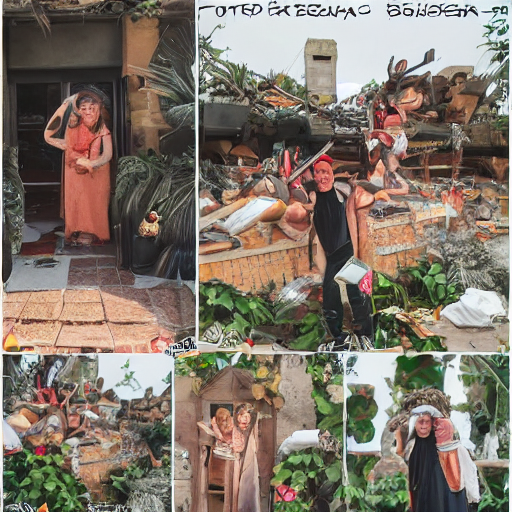

In [154]:
import random
from PIL import Image
torch_device = device
negative_prompt = None
batch_size = 1
height = 512
width = 512
ddim_steps = 50
guidance_scale = 7.5
seed = 100

generator = torch.manual_seed(seed) 
text_input = tokenizer('', padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
if negative_prompt is None:
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
else:
    uncond_input = tokenizer(
        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

noise_scheduler.set_timesteps(ddim_steps)

latents = latents * noise_scheduler.init_noise_sigma

latent_model_input = torch.cat([latents] * 2)
for t in tqdm(noise_scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]
# noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

In [158]:
import random
from PIL import Image
torch_device = device
negative_prompt = None
batch_size = 1
height = 512
width = 512
ddim_steps = 50
guidance_scale = 7.5
seed = 100

generator = torch.manual_seed(seed) 
text_input = tokenizer('', padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
if negative_prompt is None:
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
else:
    uncond_input = tokenizer(
        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

noise_scheduler.set_timesteps(ddim_steps)

latents = latents * noise_scheduler.init_noise_sigma

latent_model_input = torch.cat([latents] * 2)
for t in tqdm(noise_scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]
# noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

/tmp/ipykernel_237038/3524235633.py:31: FutureWarning: Accessing config attribute `in_channels` directly via 'MyUNet' object attribute is deprecated. Please access 'in_channels' over 'MyUNet's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_237038/3524235633.py:49 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_237038/3524235633.py'                       │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1501   │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_conditio │
│ n.py:930 in forward                                                                              │
│                                                                                                  │
│    927 │   │   │   │   if is_adapter and len(down_block_additional_residuals) > 0:               │
│    928 │   │   │   │   │   additional_residuals["additional_residuals"] = down_block_additional  │
│    929 │   │   │   │                                                                             │
│ ❱  930 │   │   │   │   sample, res_samples = downsample_block(                                   │
│    931 │   │   │   │   │   hidden_states=sample,                                                 │
│    932 │   │   │   │   │   temb=emb,                                                             │
│    933 │   │   │   │   │   encoder_hidden_states=encoder_hidden_states,                          │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1501   │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /share/u/rohit/.conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_blocks.p │
│ y:1053 in forward                                          

In [ ]:
iterations = 500
ddim_steps = 50
img_size = 512
pbar = tqdm(range(iterations))
for i in pbar:
    with torch.no_grad():
        noise_scheduler.set_timesteps(
            ddim_steps, device=device
        )

        optimizer.zero_grad()

        prompt_pair: PromptEmbedsPair = prompt_pairs[
            torch.randint(0, len(prompt_pairs), (1,)).item()
        ]

        
        random_time_step = torch.randint(
            1, ddim_steps, (1,)
        ).item()

        height, width = (
            img_size,
            img_size,
        )

        init_latents = torch.randn(
            (batch_size, unet.in_channels, height // 8, width // 8),
        )

        predicted_noise = 
            # ちょっとデノイズされれたものが返る
            denoised_latents = train_util.diffusion(
                unet,
                noise_scheduler,
                latents,  # 単純なノイズのlatentsを渡す
                train_util.concat_embeddings(
                    prompt_pair.unconditional,
                    prompt_pair.target,
                    prompt_pair.batch_size,
                ),
                start_timesteps=0,
                total_timesteps=timesteps_to,
                guidance_scale=3,
            )

        noise_scheduler.set_timesteps(1000)

        current_timestep = noise_scheduler.timesteps[
            int(timesteps_to * 1000 / config.train.max_denoising_steps)
        ]

        # with network: の外では空のLoRAのみが有効になる
        positive_latents = train_util.predict_noise(
            unet,
            noise_scheduler,
            current_timestep,
            denoised_latents,
            train_util.concat_embeddings(
                prompt_pair.unconditional,
                prompt_pair.positive,
                prompt_pair.batch_size,
            ),
            guidance_scale=1,
        ).to("cpu", dtype=torch.float32)
        neutral_latents = train_util.predict_noise(
            unet,
            noise_scheduler,
            current_timestep,
            denoised_latents,
            train_util.concat_embeddings(
                prompt_pair.unconditional,
                prompt_pair.neutral,
                prompt_pair.batch_size,
            ),
            guidance_scale=1,
        ).to("cpu", dtype=torch.float32)
        unconditional_latents = train_util.predict_noise(
            unet,
            noise_scheduler,
            current_timestep,
            denoised_latents,
            train_util.concat_embeddings(
                prompt_pair.unconditional,
                prompt_pair.unconditional,
                prompt_pair.batch_size,
            ),
            guidance_scale=1,
        ).to("cpu", dtype=torch.float32)

        if config.logging.verbose:
            print("positive_latents:", positive_latents[0, 0, :5, :5])
            print("neutral_latents:", neutral_latents[0, 0, :5, :5])
            print("unconditional_latents:", unconditional_latents[0, 0, :5, :5])

    with network:
        target_latents = train_util.predict_noise(
            unet,
            noise_scheduler,
            current_timestep,
            denoised_latents,
            train_util.concat_embeddings(
                prompt_pair.unconditional,
                prompt_pair.target,
                prompt_pair.batch_size,
            ),
            guidance_scale=1,
        ).to("cpu", dtype=torch.float32)

        if config.logging.verbose:
            print("target_latents:", target_latents[0, 0, :5, :5])

    positive_latents.requires_grad = False
    neutral_latents.requires_grad = False
    unconditional_latents.requires_grad = False

    loss = prompt_pair.loss(
        target_latents=target_latents,
        positive_latents=positive_latents,
        neutral_latents=neutral_latents,
        unconditional_latents=unconditional_latents,
    )

    # 1000倍しないとずっと0.000...になってしまって見た目的に面白くない
    pbar.set_description(f"Loss*1k: {loss.item()*1000:.4f}")
    if config.logging.use_wandb:
        wandb.log(
            {"loss": loss, "iteration": i, "lr": lr_scheduler.get_last_lr()[0]}
        )

    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    del (
        positive_latents,
        neutral_latents,
        unconditional_latents,
        target_latents,
        latents,
    )
    flush()

    if (
        i % config.save.per_steps == 0
        and i != 0
        and i != config.train.iterations - 1
    ):
        print("Saving...")
        save_path.mkdir(parents=True, exist_ok=True)
        network.save_weights(
            save_path / f"{config.save.name}_{i}steps.safetensors",
            dtype=save_weight_dtype,
        )

    print("Saving...")
    save_path.mkdir(parents=True, exist_ok=True)
    network.save_weights(
    save_path / f"{config.save.name}_last.safetensors",
    dtype=save_weight_dtype,
    )

    del (
    unet,
    noise_scheduler,
    loss,
    optimizer,
    network,
    )

    flush()

    print("Done.")